# Semantic Segmentation
Implementation of FCN-32s architecture for semantic segmentation.

[Paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)

## Architecture

- VGG16

- Conv2D, 7x7, 4096, relu, same

- Dropout 0.5

- Conv2D, 1x1, 4096, relu, same

- Dropout 0.5

- Conv2D nb_classes 1x1

- x = Conv2DTranspose(filters=nb_classes, kernel_size=(64, 64), strides=(33, 32), padding='same', activation='sigmoid')(x)

- Cropping2D

## Set-up

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import random
import numpy as np
import tensorflow as tf

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.set_random_seed(seed)

## Data

In [0]:
!wget https://www.mimuw.edu.pl/~bilinski/VRNN2019/labs/datasets/segmentation.npz  > /dev/null 2>&1

In [0]:
# Data is already preprocessed for VGG16
data = np.load('segmentation.npz')
x_train, y_train, x_test, y_test = data['train_x'], data['train_y'], data['test_x'], data['test_y']
del data

## Model

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Conv2DTranspose, Cropping2D, Dense


def FCN32_VGG16(input_shape, n_classes):
    inputs = Input(shape=input_shape)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    conv1 = Conv2D(filters=4096, kernel_size=(7, 7), activation='relu', padding='same')(vgg16.output)
    drop1 = Dropout(0.5)(conv1)

    conv2 = Conv2D(filters=4096, kernel_size=(1, 1), activation='relu', padding='same')(drop1)
    drop2 = Dropout(0.5)(conv2)

    conv3 = Conv2D(filters=n_classes, kernel_size=(1, 1))(drop2)
    out = Conv2DTranspose(filters=n_classes, kernel_size=(64, 64), strides=(33, 32), padding='same', activation='sigmoid')(conv3)
    out = Cropping2D(cropping=((2, 1), (0, 0)))(out)

    model = Model(inputs=inputs, outputs=out, name='FCN32_VGG16')

    return model

In [0]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adadelta

input_shape = x_train.shape[1:]
n_classes = y_train.shape[3]
disabled_layers = 15

model = FCN32_VGG16(input_shape, n_classes)

for layer in model.layers[:disabled_layers]:
    layer.trainable = False

model.compile(optimizer=Adadelta(learning_rate=0.5), loss='categorical_crossentropy', metrics=['accuracy', MeanIoU(n_classes)])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
print(model.summary())

print('\nTrainable status:')
for layer in model.layers:
    print(layer.name, layer.trainable)

Model: "FCN32_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 120, 128)      

## DataGenerator

In [0]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size, shuffle=False):
        self.x, self.y = x, y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.x))
        self.shuffle = shuffle
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.x.shape[0] // self.batch_size)

    def __getitem__(self, index):
        'Generates one batch of data'
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]
        return batch_x, batch_y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indices)


class DataGeneratorSimple(Sequence):
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.x.shape[0] // self.batch_size)

    def __getitem__(self, index):
        'Generates one batch of data'
        batch_x = self.x[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        return batch_x, batch_y

## Training

In [0]:
batch_size = 3
epochs = 20

model.fit_generator(DataGenerator(x_train, y_train, batch_size, shuffle=True), 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
122/122 [==============================] - 40s 325ms/step - loss: 1.4026 - acc: 0.5239 - mean_io_u: 0.5255 - val_loss: 1.0977 - val_acc: 0.5520 - val_mean_io_u: 0.4621
Epoch 2/20
122/122 [==============================] - 33s 274ms/step - loss: 0.7697 - acc: 0.6934 - mean_io_u: 0.4697 - val_loss: 0.6597 - val_acc: 0.8139 - val_mean_io_u: 0.4584
Epoch 3/20
122/122 [==============================] - 33s 274ms/step - loss: 0.5365 - acc: 0.8299 - mean_io_u: 0.4593 - val_loss: 0.5104 - val_acc: 0.8390 - val_mean_io_u: 0.4583
Epoch 4/20
122/122 [==============================] - 34s 275ms/step - loss: 0.4547 - acc: 0.8549 - mean_io_u: 0.4589 - val_loss: 0.4400 - val_acc: 0.8568 - val_mean_io_u: 0.4585
Epoch 5/20
122/122 [==============================] - 34s 275ms/step - loss: 0.3928 - acc: 0.8719 - mean_io_u: 0.4589 - val_loss: 0.4168 - val_acc: 0.8616 - val_mean_io_u: 0.4584
Epoch 6/20


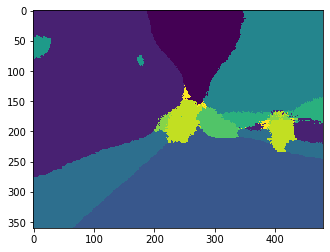

In [0]:
import matplotlib.pyplot as plt
pred = model.predict(np.expand_dims(x_test[0], axis=0))[0].argmax(axis=2)
plt.imshow(pred)

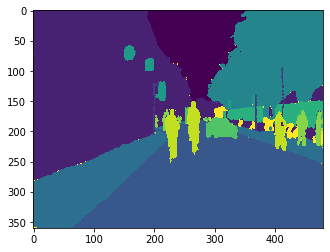

In [0]:
plt.imshow(y_test[0].argmax(axis=2))

## Save a trained model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model.save('/content/gdrive/My Drive/Machine Learning/fcn32.h5')

## Load the trained model and evaluate it on the test set

In [0]:
from tensorflow.keras.models import load_model

model = load_model('/content/gdrive/My Drive/Machine Learning/fcn32.h5')
model.evaluate(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
101/101 [==============================] - 7s 71ms/sample - loss: 0.3463 - acc: 0.8963 - mean_io_u: 0.4752


[0.3462792661520514, 0.89631265, 0.47518826]

### Usefull commands

*   !nvidia-smi

